In [1]:
%reset
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from info import info
from pdf_computer import pdfComputer
from sst import conductSST

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Settings for plot
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

# Function for a coupled two-species nonlienar logistic difference system with chaotic dynamics
def two_species_logistic(x0, y0, N):
    x = lambda x, y: x*(3.8-3.8*x-.02*y)
    y = lambda x, y: y*(3.5-3.5*y-0.1*x)

    x_set = np.zeros(N)
    y_set = np.zeros(N)
    x_set[0] = x0
    y_set[0] = y0
    
    for i in range(N-1):
        xnow, ynow = x_set[i], y_set[i]
        x_set[i+1] = x(xnow, ynow)
        y_set[i+1] = y(xnow, ynow)
    
    return x_set, y_set

# Parameter settings
x0, y0 = .8, .8
N      = 2000
s_set  = [0, 730, 315, 0]
e_set  = [13, 750, 350, 1000]

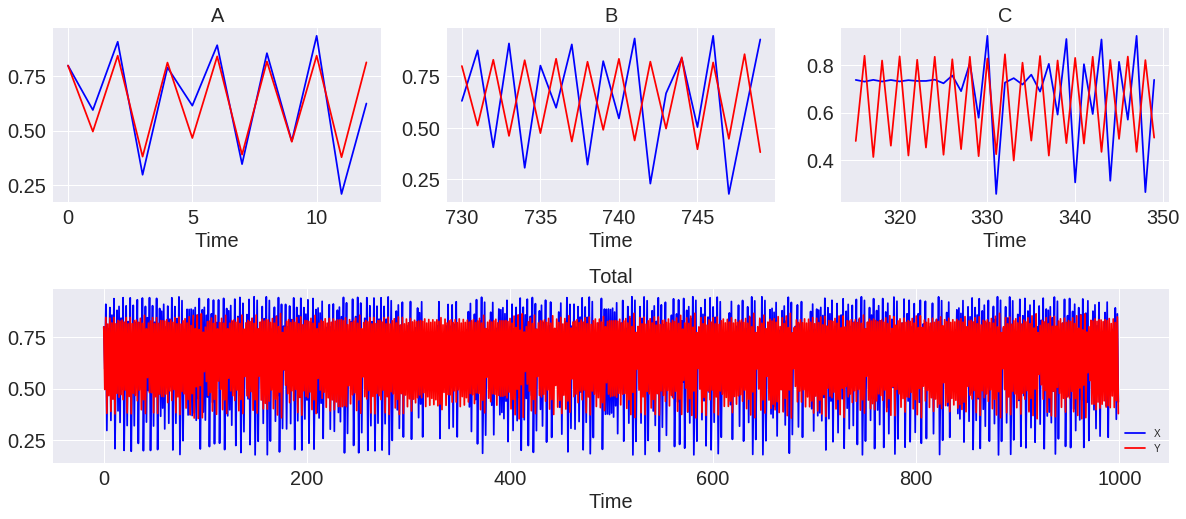

In [3]:
# Simulate it
x_set, y_set = two_species_logistic(x0, y0, N)

# Plot it
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.2, hspace=0.5)

start, end = s_set[0], e_set[0]
t_set = range(start, end)
ax = plt.subplot(gs[0, 0])
ax.plot(t_set, x_set[start:end], 'b')
ax.plot(t_set, y_set[start:end], 'r')
ax.set_title('A')
ax.set_xlabel('Time')

start, end = s_set[1], e_set[1]
t_set = range(start, end)
ax = plt.subplot(gs[0, 1])
ax.plot(t_set, x_set[start:end], 'b')
ax.plot(t_set, y_set[start:end], 'r')
ax.set_title('B')
ax.set_xlabel('Time')

start, end = s_set[2], e_set[2]
t_set = range(start, end)
ax = plt.subplot(gs[0, 2])
ax.plot(t_set, x_set[start:end], 'b')
ax.plot(t_set, y_set[start:end], 'r')
ax.set_title('C')
ax.set_xlabel('Time')

start, end = s_set[3], e_set[3]
t_set = range(start, end)
ax = plt.subplot(gs[1, :])
ax.plot(t_set, x_set[start:end], 'b', label='X')
ax.plot(t_set, y_set[start:end], 'r', label='Y')
ax.set_title('Total')
ax.set_xlabel('Time')
le = ax.legend(loc='lower right', shadow=True)
frame = le.get_frame()
# frame.set_facecolor('0.90')

# # Set the fontsize
# for label in le.get_texts():
#     label.set_fontsize('large')

# for label in le.get_lines():
#     label.set_linewidth(1.5)  # the legend line width

plt.show()

In [4]:
# Calculate the correlation and the mutual information of the four plots
mi, mip, corr  = np.zeros(4), np.zeros(4, dtype=bool), np.zeros(4)
pdfsolver = pdfComputer(ndim=2, approach='kde_cuda', bandwidth='silverman')
nx, ny    = 100, 100
for i in range(4):
    start, end = s_set[i], e_set[i]
    data = np.array([x_set[start:end], y_set[start:end]])
    
    # Correlation
    corr[i] = np.corrcoef(data)[0,1]
    
    # Mutual information
    mip[i], mi[i], m, st = conductSST(data[0,:], data[1,:], nx, ny, 
                               approach='kde_cuda', atomCheck=True, returnTrue=True)
#     print m, st

df = pd.DataFrame(np.array([mi,mip,corr], dtype=object),
                  index=['mutual information','significance test (MI)','correlation coefficient'],
                  columns=['a','b','c','d'])
print 'X[t] ~ Y[t]'
print df

info.py:181: RuntimeWarning: invalid value encountered in divide
  ypdfs_x_log, ypdfs_x = np.ma.log(xypdfs/xpdfs), np.ma.divide(xypdfs, xpdfs)
info.py:211: RuntimeWarning: invalid value encountered in divide
  ixypdf_log = np.ma.log(pdfs/(xpdfs*ypdfs))


X[t] ~ Y[t]
                                a         b         c         d
mutual information       0.737934  0.327894  0.124348  0.105476
significance test (MI)       True     False     False      True
correlation coefficient  0.917738  -0.41507 -0.267227  0.112999


In [5]:
# Calculate the mutual information with lag
mip_xl, mi_xl, mx, stx = conductSST(x_set[:-1], y_set[1:], nx, ny, approach='kde_cuda', atomCheck=True, returnTrue=True)
mip_yl, mi_yl, my, sty = conductSST(x_set[1:], y_set[:-1], nx, ny, approach='kde_cuda', atomCheck=True, returnTrue=True)
df2 = pd.DataFrame(np.array([[mi_xl, mi_yl], [mip_xl, mip_yl]], dtype=object),
                   index=['mutual information','significance test (MI)'],
                   columns=['X[t] ~ Y[t+1]','X[t+1] ~ Y[t]'])
print df2

                       X[t] ~ Y[t+1] X[t+1] ~ Y[t]
mutual information          0.205531     0.0606387
significance test (MI)          True          True
